In [21]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression)

from pydrake.solvers.mosek import MosekSolver


p = AcrobotParams()

m1 = p.m1()
m2 = p.m2()
l1 = p.l1()
lc1 = p.lc1()
lc2 = p.lc2()
Ic1 = p.Ic1()
Ic2 = p.Ic2()
b1 = p.b1()
b2 = p.b2()
gravity = p.gravity()

I1 = Ic1 + m1*lc1**2
I2 = Ic2 + m2*lc2**2

# enter the linearized matrices
E = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2, I2 + m2*l1*lc2], \
              [0, 0, I2 + m2*l1*lc2, I2]])

A = np.array([[0, 0, -1, 0], \
              [0, 0, 0, -1], \
              [-m1*gravity*lc1+m2*gravity*(-l1-lc2), -m2*gravity*lc2, b1, 0], \
              [-m2*gravity*lc2, -m2*gravity*lc2, 0, b2]])

B = np.array([[0], [0], [0], [-1]])

A = -A
B = -B

Q = np.diag([10, 10, 1, 1])
R = [1]

X, L, K_original = control.care(A, B, Q, R, E=E)

In [78]:
E

array([[1.   , 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , 0.   ],
       [0.   , 0.   , 4.663, 2.33 ],
       [0.   , 0.   , 2.33 , 1.33 ]])

In [79]:
A

array([[-0.   , -0.   ,  1.   , -0.   ],
       [-0.   , -0.   , -0.   ,  1.   ],
       [24.525,  9.81 , -0.1  , -0.   ],
       [ 9.81 ,  9.81 , -0.   , -0.1  ]])

In [80]:
K

array([[-278.44223126, -112.29125985, -119.72457377,  -56.82824017]])

In [3]:
K_casted = np.insert(K, 1, 0)
K_casted = np.insert(K_casted, 3, 0)
K_casted

array([-278.44223126,    0.        , -112.29125985,    0.        ,
       -119.72457377,  -56.82824017])

In [4]:
A_cloop = A-B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E = E.T)

np.linalg.eigvals(P)

array([2.10360973e+03, 2.05043095e+00, 9.98528759e-01, 7.65896243e-03])

In [5]:
t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")

x = np.hstack([t1, t2, td1, td2])
V_candidate = x.T@E.T@P@E@x
Polynomial(V_candidate)

<Polynomial "80.91247036766552*td2^2 + 325.76452518070187*td1 * td2 + 328.06019370446921*td1^2 + 325.00590715317509*t2 * td2 + 654.32926244338728*t2 * td1 + 327.48490678102974*t2^2 + 754.43992843215551*t1 * td2 + 1519.4572447750918*t1 * td1 + 1515.5320202469929*t1 * t2 + 1760.7194856732497*t1^2">

In [6]:
# finding the bound
negative_infinity = float('-inf')
coeff = 1e-2
positive_infinity = float('inf')

def find_implicit_lambdas(x, xd, V, Vdot, g, x_0, u):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    rho = prog.NewContinuousVariables(1, 'rho')[0]
    
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(Vdot.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
    
    s_deg = max(l_deg + Vdot.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    lambda_s2 = prog.NewFreePolynomial(Variables(y), s_deg)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)    
    trig2 = Polynomial(x[2]**2 + x[3]**2 - 1)

    prog.AddSosConstraint(Polynomial((x-x_0).dot(x-x_0))*(V - rho) -lambda_*Vdot \
                          + lambda_g.dot(g) + lambda_s*trig + lambda_s2*trig2)
    
#     prog.AddSosConstraint(Vdot + Polynomial((x-x_0).dot(x-x_0)) + lambda_*(V + 362) + \
#                           lambda_g.dot(g) + lambda_s*trig + lambda_s2*trig2)
    
    prog.AddLinearCost(-rho)
    #prog.AddLinearConstraint(rho, 0, positive_infinity)
    
    
        
    solver = MosekSolver()
    result = solver.Solve(prog)

    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff), np.array(lambda_g_results), \
result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff)\
, result.GetSolution(rho)

def verify_V_positive_definite(x, V): 
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)    
    trig2 = Polynomial(x[2]**2 + x[3]**2 - 1)
    
    s_deg = max(V.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(x), s_deg)
    lambda_s2 = prog.NewFreePolynomial(Variables(x), s_deg)
    
    prog.AddSosConstraint(V + lambda_s*trig + lambda_s2*trig2)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
    print("V assertion solution status: " + str(k))
    
    assert result.is_success()
    
    print('Reached here means result is success')

def problem_solver_implicit(V_degree, G):
    prog = MathematicalProgram()
    s1 = prog.NewIndeterminates(1, "s1")
    c1 = prog.NewIndeterminates(1, "c1")
    s2 = prog.NewIndeterminates(1, "s2")
    c2 = prog.NewIndeterminates(1, "c2")
    td1 = prog.NewIndeterminates(1, "\dot{t1}")
    td2 = prog.NewIndeterminates(1, "\dot{t2}")
    
    x = np.hstack([s1, c1, s2, c2, td1, td2])
    x_0 = np.array([0, 1, 0, 1, 0, 0])
    
    xd = prog.NewIndeterminates(6, 'xd')

    u = -G@(x - x_0)
            
    g0 = xd[0] - c1[0]*td1[0]
    g1 = xd[1] + s1[0]*td1[0]
    g2 = xd[2] - c2[0]*td2[0]
    g3 = xd[3] + s2[0]*td2[0]
    g4 = I1*xd[4] + I2*xd[4] + m2*l1**2*xd[4] * 2*m2*l1*lc2*c2[0]*xd[4] + \
            I2*xd[5] + m2*l1*lc2*c2[0]*xd[5] - 2*m2*l1*lc2*s2[0]*td1[0]*td2[0] - \
                m2*l1*lc2*s2[0]*td2[0]**2 - \
                    m1*gravity*lc1*s1[0] + m2*gravity*(-l1*s1[0] + lc2*(-s1[0]*c2[0] - c1[0]*s2[0]))
    g5 = I2*xd[4] + m2*l1*lc2*c2[0]*xd[4] + I2*xd[5] + m2*l1*lc2*s2[0]*td1[0]**2 + \
            m2*gravity*lc2*(-s1[0]*c2[0] - c1[0]*s2[0]) - u
        
    g = np.array([g0, g1, g2, g3, g4, g5])
    
    
    V = 80.91247036766552*td2[0]**2 + 325.76452518070187*td1[0] * td2[0] + 328.06019370446921*td1[0]**2 + \
    325.00590715317509*s2[0] * td2[0] + 654.32926244338728*s2[0] * td1[0] + 327.48490678102974*(2-2*c2[0]) + \
    754.43992843215551*s1[0] * td2[0] + 1519.4572447750918*s1[0] * td1[0] + 1515.5320202469929*s1[0] * s2[0] + \
    1760.7194856732497*(2-2*c1[0])
    
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    for i in range(1):
        lambda_, lambda_g, lambda_s, rho = find_implicit_lambdas(x, xd, V, Vdot, g_poly, x_0, Polynomial(u))
        
        verify_V_positive_definite(x, V)
        print(rho)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(V_degree, K_casted)

Lambda solution status: 1
V assertion solution status: 1
Reached here means result is success
0.0017623894685293298


$ V(x)=(4176.408784909 - 3521.438971346c1_{0} - 654.969813562c2_{0} + 1515.532020247s1_{0} s2_{0} + 1519.457244775s1_{0} \dot{t1}_{0} + 754.439928432s1_{0} \dot{t2}_{0} + 654.329262443s2_{0} \dot{t1}_{0} + 325.005907153s2_{0} \dot{t2}_{0} + 325.764525181\dot{t1}_{0} \dot{t2}_{0} + 328.060193704\dot{t1}_{0}^{2} + 80.912470368\dot{t2}_{0}^{2})$

In [29]:
# finding the bound
negative_infinity = float('-inf')
coeff = 1e-2
positive_infinity = float('inf')

def find_implicit_lambdas(x, xd, V, Vdot, g, x_0, u):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    #rho = prog.NewContinuousVariables(1, 'rho')[0]
    
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(Vdot.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
    
    s_deg = max(l_deg + Vdot.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    lambda_s2 = prog.NewFreePolynomial(Variables(y), s_deg)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)    
    trig2 = Polynomial(x[2]**2 + x[3]**2 - 1)
    
    rho = 1e-6
    prog.AddSosConstraint(-Vdot + lambda_*(V - rho) \
                         + lambda_g.dot(g) + lambda_s*trig + lambda_s2*trig2)
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff), np.array(lambda_g_results), \
result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff)\
, result.GetSolution(rho)

def problem_solver_implicit(V_degree, G):
    prog = MathematicalProgram()
    s1 = prog.NewIndeterminates(1, "s1")
    c1 = prog.NewIndeterminates(1, "c1")
    s2 = prog.NewIndeterminates(1, "s2")
    c2 = prog.NewIndeterminates(1, "c2")
    td1 = prog.NewIndeterminates(1, "\dot{t1}")
    td2 = prog.NewIndeterminates(1, "\dot{t2}")
    
    x = np.hstack([s1, c1, s2, c2, td1, td2])
    x_0 = np.array([0, 1, 0, 1, 0, 0])
    
    xd = prog.NewIndeterminates(6, 'xd')

    u = -G@(x - x_0)
            
    g0 = xd[0] - c1[0]*td1[0]
    g1 = xd[1] + s1[0]*td1[0]
    g2 = xd[2] - c2[0]*td2[0]
    g3 = xd[3] + s2[0]*td2[0]
    g4 = I1*xd[4] + I2*xd[4] + m2*l1**2*xd[4] * 2*m2*l1*lc2*c2[0]*xd[4] + \
            I2*xd[5] + m2*l1*lc2*c2[0]*xd[5] - 2*m2*l1*lc2*s2[0]*td1[0]*td2[0] - \
                m2*l1*lc2*s2[0]*td2[0]**2 - \
                    m1*gravity*lc1*s1[0] + m2*gravity*(-l1*s1[0] + lc2*(-s1[0]*c2[0] - c1[0]*s2[0]))
    g5 = I2*xd[4] + m2*l1*lc2*c2[0]*xd[4] + I2*xd[5] + m2*l1*lc2*s2[0]*td1[0]**2 + \
            m2*gravity*lc2*(-s1[0]*c2[0] - c1[0]*s2[0]) - u
        
    g = np.array([g0, g1, g2, g3, g4, g5])
    
    
    V = 80.91247036766552*td2[0]**2 + 325.76452518070187*td1[0] * td2[0] + 328.06019370446921*td1[0]**2 + \
    325.00590715317509*s2[0] * td2[0] + 654.32926244338728*s2[0] * td1[0] + 327.48490678102974*(2-2*c2[0]) + \
    754.43992843215551*s1[0] * td2[0] + 1519.4572447750918*s1[0] * td1[0] + 1515.5320202469929*s1[0] * s2[0] + \
    1760.7194856732497*(2-2*c1[0])
    
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    for i in range(1):
        lambda_, lambda_g, lambda_s, rho = find_implicit_lambdas(x, xd, V, Vdot, g_poly, x_0, Polynomial(u))
        
        #verify_V_positive_definite(x, V)
        print(rho)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(V_degree, K_casted)

Lambda solution status: 5


AssertionError: 

In [12]:
list(V.indeterminates())

[Variable('s1(0)', Continuous),
 Variable('c1(0)', Continuous),
 Variable('s2(0)', Continuous),
 Variable('c2(0)', Continuous),
 Variable('\dot{t1}(0)', Continuous),
 Variable('\dot{t2}(0)', Continuous)]

In [13]:
var_list = list(V.indeterminates())
s1 = var_list[0]
c1 = var_list[1]
s2 = var_list[2]
c2 = var_list[3]
td1 = var_list[4]
td2 = var_list[5]

env = {s1:0, c1:1, s2:0, c2:1, td1:0, td2:0}


V.Evaluate(env)


4.547473508864641e-13

In [14]:
# try out the controller
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")
garbage = Variable("garbage")

x = np.hstack([t1, t2, td1, td2])
u = -K@(x  - UprightState().CopyToVector())

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

M = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*pf.cos(t2), I2 + m2*l1*lc2*pf.cos(t2)], \
              [0, 0, I2 + m2*l1*lc2*pf.cos(t2), I2]])

K2 = B.T@X@M
u_new = -K2@(x - UprightState().CopyToVector())

own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u_new)

def acrobot_balancing_example(use_new, num_itr, plotting, max_seed):
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    
    if use_new: 
        controller = builder.AddSystem(own_controller_new)
    else:
        controller = builder.AddSystem(own_controller)
        
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)

#     # Setup visualization
#     scene_graph = builder.AddSystem(SceneGraph())
#     AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    
#     simulator = Simulator(diagram)
#     context = simulator.get_mutable_context()
#     print(context)
#     display(SVG(pydot.graph_from_dot_data(
#     diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 8
    
    points = []
    points_failed = []
    
    seeds = np.linspace(10000, max_seed, num_itr)
    
    disturbance = np.linspace(0, 0.5, num_itr)
    
    start_time = time.time()
    
    failed_V = []
    success_V = []
    for i in range(num_itr):
        context.SetTime(0.)
        
        np.random.seed(int(seeds[i]))
        #print(np.random.randn(2))
        trial = np.append(UprightState().CopyToVector(), 0) + \
                                0.05 * np.append(np.random.randn(2,), np.zeros(3))
        
        env[s1] = np.sin(trial[0] - np.pi)
        env[c1] = np.cos(trial[0] - np.pi)
        env[s2] = np.sin(trial[1])
        env[c2] = np.cos(trial[1])
        env[td1] = trial[2]
        env[td2] = trial[3]
        
        V_evaluated = V.Evaluate(env)
        
            
        context.SetContinuousState(trial)
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        
        if plotting: 
            plt.figure(figsize=(5, 4))
            plt.plot(log.sample_times(), log.data().transpose())
            plt.xlabel('t')
            plt.ylabel('y(t)')
        
        # teta = log.data()[0]
        t1_end = log.data()[0][-1]
        t2_end = log.data()[1][-1]
        t1d_end = log.data()[2][-1]
        t2d_end = log.data()[3][-1]
        
        if  t1_end - np.pi < 5*1e-2 and t2_end - 0 < 5e-2 and t1d_end - 0 < 5e-2 and t2d_end - 0 < 5e-2:
            points.append(trial[:-1])
            success_V.append(V_evaluated)
        else: 
            points_failed.append(trial[:-1])
            failed_V.append(V_evaluated)
        
#         avg_angle = np.average(teta[2*int(len(teta)/3):])
# #         print(avg_angle)
#         if  avg_angle - np.pi < 2*1e-2:
#             points.append(trial[:-1])
#             success_V.append(V_evaluated)
#         else: 
#             points_failed.append(trial[:-1])
#             failed_V.append(V_evaluated)
            
        if i%500 == 0: 
            print("Reached", str(i))
        
    run_time = time.time() - start_time 
    print("Loop ended took", str(run_time))
    return points, points_failed, failed_V, success_V

num_itr = 10000
plotting = False
max_seed = 30000

points_new, points_failed_new, failed_V_new, \
    success_V_new = acrobot_balancing_example(True, num_itr, plotting, max_seed)
points, points_failed, failed_V, success_V = acrobot_balancing_example(False, num_itr, plotting, max_seed)

Reached 0
Reached 500
Reached 1000
Reached 1500
Reached 2000
Reached 2500
Reached 3000
Reached 3500
Reached 4000
Reached 4500
Reached 5000
Reached 5500
Reached 6000
Reached 6500
Reached 7000
Reached 7500
Reached 8000
Reached 8500
Reached 9000
Reached 9500
Loop ended took 79.97414088249207
Reached 0
Reached 500
Reached 1000
Reached 1500
Reached 2000
Reached 2500
Reached 3000
Reached 3500
Reached 4000
Reached 4500
Reached 5000
Reached 5500
Reached 6000
Reached 6500
Reached 7000
Reached 7500
Reached 8000
Reached 8500
Reached 9000
Reached 9500
Loop ended took 122.74219799041748


In [15]:
points_failed = np.array(points_failed)
points = np.array(points)
points_new = np.array(points_new)
points_failed_new = np.array(points_failed_new)

In [16]:
len(points)

7509

In [17]:
len(points_new)

8734

<IPython.core.display.Javascript object>


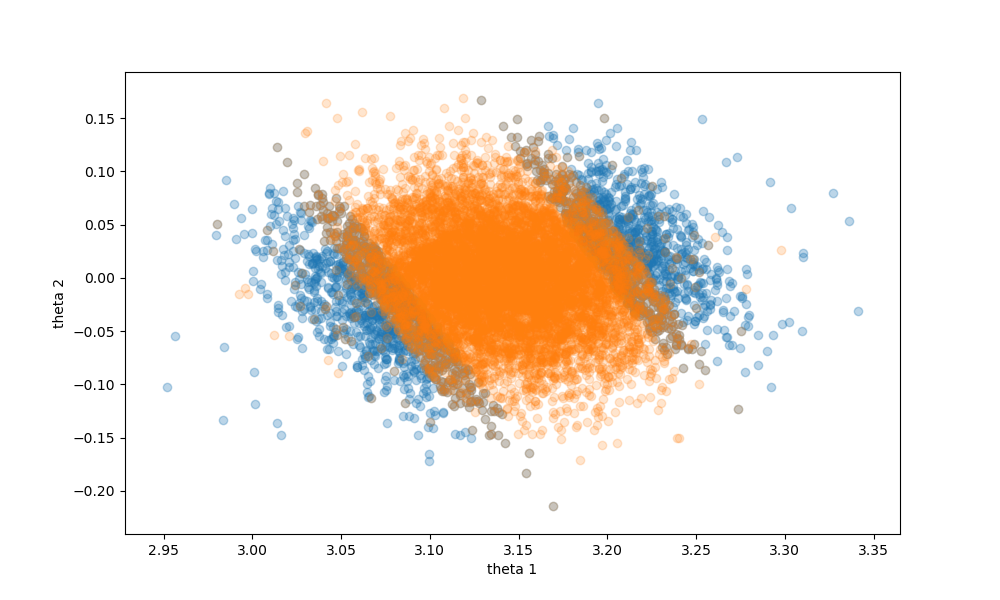

Text(0, 0.5, 'theta 2')

In [18]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

img = ax.scatter(points_failed[:, 0], points_failed[:, 1], alpha = 0.3)
img2 = ax.scatter(points_new[:, 0], points_new[:, 1], alpha=0.2)

ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")

In [60]:
tr1 = np.linspace(np.pi/2, (3*np.pi)/2, 1000)
tr2 = np.linspace(-np.pi/2, np.pi/2, 1000)

TR1, TR2 = np.meshgrid(tr1, tr2)

In [61]:
np.shape(TR1)

(1000, 1000)

In [66]:
# try out the controller
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")
garbage = Variable("garbage")

x = np.hstack([t1, t2, td1, td2])
u = -K@(x  - UprightState().CopyToVector())

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

M = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*pf.cos(t2), I2 + m2*l1*lc2*pf.cos(t2)], \
              [0, 0, I2 + m2*l1*lc2*pf.cos(t2), I2]])

K2 = B.T@X@M
u_new = -K2@(x - UprightState().CopyToVector())

own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u_new)

def acrobot_balancing_example(use_new, num_itr, plotting):
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-3], max_value=[3]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    
    if use_new: 
        controller = builder.AddSystem(own_controller_new)
    else:
        controller = builder.AddSystem(own_controller)
        
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)

#     # Setup visualization
#     scene_graph = builder.AddSystem(SceneGraph())
#     AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    
#     simulator = Simulator(diagram)
#     context = simulator.get_mutable_context()
#     print(context)
#     display(SVG(pydot.graph_from_dot_data(
#     diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 16
        
    disturbance = np.linspace(0, 0.5, num_itr)
    
    start_time = time.time()
    
    failed_V = []
    success_V = []
    
    tr1 = np.linspace(np.pi/2, (3*np.pi)/2, num_itr)
    tr2 = np.linspace(-np.pi/2, np.pi/2, num_itr)

    TR1, TR2 = np.meshgrid(tr1, tr2)
    
    worked_arr = np.zeros_like(TR1)
    V_eval_arr = np.zeros_like(TR1)
    for i in range(len(TR1)):
        for j in range(len(TR1[i])):
            context.SetTime(0.)

            trial = np.array([TR1[i, j], TR2[i, j], 0, 0, 0])

            context.SetContinuousState(trial)
            simulator.Initialize()
            simulator.AdvanceTo(duration)

            log = logger.FindLog(context)

            if plotting: 
                plt.figure(figsize=(5, 4))
                plt.plot(log.sample_times(), log.data().transpose())
                plt.xlabel('t')
                plt.ylabel('y(t)')
            
            state_end = log.data()[:, -1]

            diff = np.abs(state_end - UprightState().CopyToVector())
            
            tolerance = 5e-2
            
            if np.sum(diff < np.ones(4)*tolerance) == 4:
                worked_arr[i, j] = 1

        if i%1 == 0: 
            print("Reached", str(i))
        
    run_time = time.time() - start_time 
    print("Loop ended took", str(run_time))
    return TR1, TR2, worked_arr, V_eval_arr

num_itr = 300
plotting = False

TR1, TR2, worked_arr, V_eval_arr = acrobot_balancing_example(False, num_itr, plotting)

np.save('./300by300TR1.npy', TR1)
np.save('./300by300TR2.npy', TR2)
np.save('./worked_arr_300.npy', worked_arr)
np.save('./V_eval_arr_300.npy', V_eval_arr)
print('Starting Other')
TR1_new, TR2_new, worked_arr_new, \
    V_eval_arr_new = acrobot_balancing_example(True, num_itr, plotting)
np.save('./worked_arr_new_300.npy', worked_arr_new)
np.save('./V_eval_arr_new_300.npy', V_eval_arr_new)

Reached 0
Reached 1
Reached 2
Reached 3
Reached 4
Reached 5
Reached 6
Reached 7
Reached 8
Reached 9
Reached 10
Reached 11
Reached 12
Reached 13
Reached 14
Reached 15
Reached 16
Reached 17
Reached 18
Reached 19
Reached 20
Reached 21
Reached 22
Reached 23
Reached 24
Reached 25
Reached 26
Reached 27
Reached 28
Reached 29
Reached 30
Reached 31
Reached 32
Reached 33
Reached 34
Reached 35
Reached 36
Reached 37
Reached 38
Reached 39
Reached 40
Reached 41
Reached 42
Reached 43
Reached 44
Reached 45
Reached 46
Reached 47
Reached 48
Reached 49
Reached 50
Reached 51
Reached 52
Reached 53
Reached 54
Reached 55
Reached 56
Reached 57
Reached 58
Reached 59
Reached 60
Reached 61
Reached 62
Reached 63
Reached 64
Reached 65
Reached 66
Reached 67
Reached 68
Reached 69
Reached 70
Reached 71
Reached 72
Reached 73
Reached 74
Reached 75
Reached 76
Reached 77
Reached 78
Reached 79
Reached 80
Reached 81
Reached 82
Reached 83
Reached 84
Reached 85
Reached 86
Reached 87
Reached 88
Reached 89
Reached 90
Reached 9

In [67]:
V

<Polynomial "4176.408784908559*1 + 25.019636572250128*\dot{t2}(0)^2 + 102.09630966587379*\dot{t1}(0) * \dot{t2}(0) + 107.00000496053462*\dot{t1}(0)^2 + -654.96981356205947*c2(0) + 39.052540526161678*c2(0) * \dot{t2}(0)^2 + 160.62481655063513*c2(0) * \dot{t1}(0) * \dot{t2}(0) + 160.7129049879122*c2(0) * \dot{t1}(0)^2 + 16.84029326925371*c2(0)^2 * \dot{t2}(0)^2 + 63.043398964192889*c2(0)^2 * \dot{t1}(0) * \dot{t2}(0) + 60.347283756022406*c2(0)^2 * \dot{t1}(0)^2 + 178.80896401403871*s2(0) * \dot{t2}(0) + 373.6894892185075*s2(0) * \dot{t1}(0) + 146.19694313913635*s2(0) * c2(0) * \dot{t2}(0) + 280.63977322487972*s2(0) * c2(0) * \dot{t1}(0) + 3521.4389713464993*c1(0) + -414.1158172339907*s1(0) * \dot{t2}(0) + -867.76785746114444*s1(0) * \dot{t1}(0) + -340.32411119816487*s1(0) * c2(0) * \dot{t2}(0) + -651.68938731394735*s1(0) * c2(0) * \dot{t1}(0) + -1515.5320202469929*s1(0) * s2(0)">

In [68]:
success_indices_new = np.where(worked_arr_new == 1)

In [69]:
success_indices = np.where(worked_arr == 1)

In [70]:
len(success_indices_new[0])

693

In [85]:
np.save('./100by100TR1.npy', TR1)
np.save('./100by100TR2.npy', TR2)
np.save('./worked_arr.npy', worked_arr)
np.save('./V_eval_arr.npy', V_eval_arr)
np.save('./worked_arr_new.npy', worked_arr_new)
np.save('./V_eval_arr_new.npy', V_eval_arr_new)

In [76]:
TR1 = np.load('./100by100TR1.npy')
TR2 = np.load('./100by100TR2.npy')
worked_arr = np.load('./worked_arr.npy')
V_eval_arr = np.load('./V_eval_arr.npy')
worked_arr_new = np.load('./worked_arr_new.npy')
V_eval_arr_new = np.load('./V_eval_arr_new.npy')
success_indices_new = np.where(worked_arr_new == 1)
success_indices = np.where(worked_arr == 1)

In [28]:
TR1_300 = np.load('./300by300TR1.npy')
TR2_300 = np.load('./300by300TR2.npy')
worked_arr_300 = np.load('./worked_arr_300.npy')
V_eval_arr_300 = np.load('./V_eval_arr_300.npy')
worked_arr_new_300 = np.load('./worked_arr_new_300.npy')
V_eval_arr_new_300 = np.load('./V_eval_arr_new_300.npy')
success_indices_new_300 = np.where(worked_arr_new_300 == 1)
success_indices_300 = np.where(worked_arr_300 == 1)
fail_indices_new_300 = np.where(worked_arr_new_300 == 0)

<IPython.core.display.Javascript object>


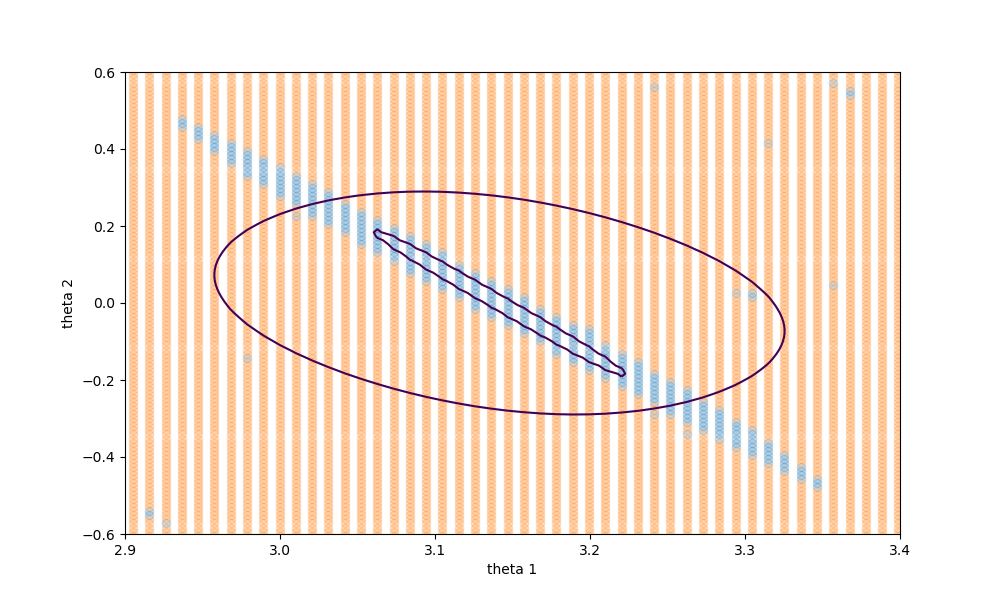

Text(0, 0.5, 'theta 2')

In [163]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#img2 = ax.scatter(TR1[ckkk2], TR2[ckkk2], alpha=0.2)
#img = ax.scatter(TR1[success_indices], TR2[success_indices], alpha=0.2)
#img = ax.scatter(TR1[success_indices_new], TR2[success_indices_new], alpha=0.2)
#img = ax.scatter(TR1_300[success_indices_300], TR2_300[success_indices_300], alpha=0.2)
img = ax.scatter(TR1_300[success_indices_new_300], TR2_300[success_indices_new_300], alpha=0.2)
img = ax.scatter(TR1_300[fail_indices_new_300], TR2_300[fail_indices_new_300], alpha=0.2)

Vplot = np.zeros_like(TR1_300)
Vdotplot = np.zeros_like(TR1_300)
env = {s1[0]:0, c1[0]:1, s2[0]:0, c2[0]:1, td1[0]:0, td2[0]:0}
for i in range(len(TR1_300)):
    for j in range(len(TR1_300[i])): 
        env[s1[0]] = np.sin(TR1_300[i, j])
        env[c1[0]] = np.cos(TR1_300[i, j])
        env[s2[0]] = np.sin(TR2_300[i, j])
        env[c2[0]] = np.cos(TR2_300[i, j])
        Vplot[i, j] = V.Evaluate(env)
        Vdotplot[i, j] = Vdot.Evaluate(env)

ax.contour(TR1_300,TR2_300, Vplot*100, levels=[2e-1])
ax.contour(TR1_300, TR2_300, Vdotplot*100, levels=[-2])
ax.set_xlim(2.9, 3.4)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")

In [117]:
V.TotalDegree()

4

In [131]:
# try out the controller
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")
garbage = Variable("garbage")

x = np.hstack([t1, t2, td1, td2])
u = -K@(x  - UprightState().CopyToVector())

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

M = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*pf.cos(t2), I2 + m2*l1*lc2*pf.cos(t2)], \
              [0, 0, I2 + m2*l1*lc2*pf.cos(t2), I2]])

K2 = B.T@X@M
u_new = -K2@(x - UprightState().CopyToVector())

own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u_new)

In [132]:
K2

array([[-278.4422312581945, -112.29125984628342,
        <Expression "(18.072653232496453 * (1.3300000000000001 + cos(t2)) - 34.705952348380265 * (2.6630000000000003 + 2 * cos(t2)))">,
        <Expression "(24.036628799220285 - 34.705952348380265 * (1.3300000000000001 + cos(t2)))">]],
      dtype=object)

In [133]:
def acrobot_balancing_example(use_new, num_itr, plotting, max_seed):
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    
    if use_new: 
        controller = builder.AddSystem(own_controller_new)
    else:
        controller = builder.AddSystem(own_controller)
        
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)

#     # Setup visualization
#     scene_graph = builder.AddSystem(SceneGraph())
#     AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    
#     simulator = Simulator(diagram)
#     context = simulator.get_mutable_context()
#     print(context)
#     display(SVG(pydot.graph_from_dot_data(
#     diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 8
    
    points = []
    points_failed = []
    
    seeds = np.linspace(10000, max_seed, num_itr)
        
    start_time = time.time()
    
    failed_V = []
    success_V = []
    for i in range(num_itr):
        context.SetTime(0.)
        
        np.random.seed(int(seeds[i]))
        trial = np.append(UprightState().CopyToVector(), 0) + \
                                0.05 * np.random.randn(5,)
        
        trial = np.array([ 1.57079633, -0.17453293, 0, 0, 0])
        
        env[s1] = np.sin(trial[0] - np.pi)
        env[c1] = np.cos(trial[0] - np.pi)
        env[s2] = np.sin(trial[1])
        env[c2] = np.cos(trial[1])
        env[td1] = trial[2]
        env[td2] = trial[3]
        
        V_evaluated = V.Evaluate(env)
        
            
        context.SetContinuousState(trial)
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        
        if plotting: 
            plt.figure(figsize=(5, 4))
            plt.plot(log.sample_times(), log.data().transpose())
            plt.xlabel('t')
            plt.ylabel('y(t)')
        
        teta = log.data()[0]
        avg_angle = np.average(teta[2*int(len(teta)/3):])
#         print(avg_angle)
        if  avg_angle - np.pi < 2*1e-2:
            points.append(trial[:-1])
            success_V.append(V_evaluated)
        else: 
            points_failed.append(trial[:-1])
            failed_V.append(V_evaluated)
            
        if i%500 == 0: 
            print("Reached", str(i))
        
    run_time = time.time() - start_time 
    print("Loop ended took", str(run_time))
    return points, points_failed, failed_V, success_V

num_itr = 1
plotting = True
max_seed = 20000

_, __, ____, _____ = acrobot_balancing_example(True, num_itr, plotting, max_seed)

TypeError: unhashable type: 'numpy.ndarray'

In [103]:
UprightState().CopyToVector() + 0.05 * np.random.randn(4,)

array([ 3.09582565,  0.00313207, -0.08825696,  0.07258637])

New approach to the Acrobot

In [1]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression, SolverOptions, CommonSolverOption, SolverOptions)

from pydrake.solvers.mosek import MosekSolver

import numpy as np

In [2]:
p = AcrobotParams()

m1 = p.m1()
m2 = p.m2()
l1 = p.l1()
lc1 = p.lc1()
lc2 = p.lc2()
Ic1 = p.Ic1()
Ic2 = p.Ic2()
b1 = p.b1()
b2 = p.b2()
gravity = p.gravity()

I1 = Ic1 + m1*lc1**2
I2 = Ic2 + m2*lc2**2

In [3]:
# enter the linearized matrices
E = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2, I2 + m2*l1*lc2], \
              [0, 0, I2 + m2*l1*lc2, I2]])

A = np.array([[0, 0, -1, 0], \
              [0, 0, 0, -1], \
              [-m1*gravity*lc1+m2*gravity*(-l1-lc2), -m2*gravity*lc2, b1, 0], \
              [-m2*gravity*lc2, -m2*gravity*lc2, 0, b2]])

B = np.array([[0], [0], [0], [-1]])

A = -A
B = -B

Q = np.diag([10, 10, 1, 1])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

A_cloop = A-B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E = E.T)

np.linalg.eigvals(P)

array([2.10360973e+03, 2.05043095e+00, 9.98528759e-01, 7.65896243e-03])

In [30]:
# def find_implicit_V(B, X, S, V): 
prog = MathematicalProgram()
t1 = prog.NewIndeterminates(1, "t1")
t2 = prog.NewIndeterminates(1, "t2")
s1 = prog.NewIndeterminates(1, "s1")
c1 = prog.NewIndeterminates(1, "c1")
s2 = prog.NewIndeterminates(1, "s2")
c2 = prog.NewIndeterminates(1, "c2")
td1 = prog.NewIndeterminates(1, "\dot{t1}")
td2 = prog.NewIndeterminates(1, "\dot{t2}")

rho = prog.NewContinuousVariables(1, 'rho')[0]
alpha = prog.NewContinuousVariables(1, 'alpha')[0]

x = np.hstack([s1, c1, s2, c2, td1, td2])
x_0 = np.array([0, -1, 0, 1, 0, 0])
z = np.hstack([t1, t2, td1, td2])

M44 = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*c2[0], I2 + m2*l1*lc2*c2[0]], \
              [0, 0, I2 + m2*l1*lc2*c2[0], I2]])

Mdot44 = np.array([[0, 0, 0, 0], \
              [0, 0, 0, 0], \
              [0, 0, -2*m2*l1*lc2*s2[0]*td2[0], -m2*l1*lc2*s2[0]*td2[0]], \
              [0, 0, -m2*l1*lc2*s2[0]*td2[0], 0]])

Vz = Polynomial(z.T@M44.T@P@M44@z)

V = 0
for m, coeff in Vz.monomial_to_coefficient_map().items(): 
    monomial = coeff
    for i in range(len(x[:-2])): 
        d = m.degree(x[i])
        monomial *= x[i]**d
    for i in range(len(z)):
        d = m.degree(z[i])
        if i==0:
            if d == 1:
                monomial *= -x[0]
            elif d == 2:
                monomial *= (2+2*x[1])
        elif i==1:
            if d == 1:
                monomial *= x[2]
            elif d == 2:
                monomial *= (2-2*x[3])
        elif i==2 or i==3:
            monomial *= x[i+2]**d
    V += monomial

V = Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5)
V = V/1000

K2 = B.T@X@M44
u = -K2@z

fz = np.array([[td1[0]], \
               [td2[0]], \
               [2*m2*l1*lc2*s2[0]*td1[0]*td2[0] + \
                m2*l1*lc2*s2[0]*td2[0]**2 - \
                    m1*gravity*lc1*s1[0] - m2*gravity*(l1*s1[0] + lc2*(s1[0]*c2[0] + c1[0]*s2[0]))], \
               [- m2*l1*lc2*s2[0]*td1[0]**2 - \
            m2*gravity*lc2*(s1[0]*c2[0] + c1[0]*s2[0]) + u[0]]])

Vdotz = fz.T@P@M44@z + z.T@Mdot44.T@P@M44@z + z.T@M44.T@P@Mdot44@z + z.T@M44.T@P@fz
Vdotz = Polynomial(Vdotz[0])

Vdot = 0
for m, coeff in Vdotz.monomial_to_coefficient_map().items(): 
    monomial = coeff
    for i in range(len(x[:-2])): 
        d = m.degree(x[i])
        monomial *= x[i]**d
    for i in range(len(z)):
        d = m.degree(z[i])
        if i==0:
            if d == 1:
                monomial *= -x[0]
            elif d == 2:
                monomial *= (2+2*x[1])
        elif i==1:
            if d == 1:
                monomial *= x[2]
            elif d == 2:
                monomial *= (2-2*x[3])
        elif i==2 or i==3:
            monomial *= x[i+2]**d
    Vdot += monomial

Vdot = Polynomial(Vdot).RemoveTermsWithSmallCoefficients(1e-5)
Vdot = Vdot/1000

s_deg = max(V.TotalDegree()-2, 0)
lambda_trig_1 = prog.NewFreePolynomial(Variables(x), s_deg)
lambda_trig_2 = prog.NewFreePolynomial(Variables(x), s_deg)
lambda_, lambda_Q = prog.NewSosPolynomial(Variables(x), 4)
# lambda_ = prog.NewFreePolynomial(Variables(x), 4)

trig_1 = Polynomial(x[0]**2 + x[1]**2 - 1)
trig_2 = Polynomial(x[2]**2 + x[3]**2 - 1)

eps = 1e-5
rho = 1e-6

prog.AddSosConstraint(-Vdot - eps*Polynomial((x-x_0).dot(x-x_0)) - alpha +\
                      lambda_trig_1*trig_1 + lambda_trig_2*trig_2 + \
                      lambda_*(V - rho))

# prog.AddSosConstraint(eps*Polynomial((x-x_0).dot(x-x_0))*(V - rho) + \
#                       lambda_trig_1*trig_1 + lambda_trig_2*trig_2 - \
#                       lambda_*Vdot)

#prog.AddCost(-rho)
prog.AddCost(-alpha)
prog.AddLinearConstraint(alpha, 1e-8, float('inf'))

lambda_enforcer_trig_1 = prog.NewFreePolynomial(Variables(x), 2)
lambda_enforcer_trig_2 = prog.NewFreePolynomial(Variables(x), 2)
lambda_enforcer_range, _ = prog.NewSosPolynomial(Variables(x), 4)

# prog.AddSosConstraint(lambda_ + lambda_enforcer_trig_1*trig_1 + lambda_enforcer_trig_2*trig_2 + \
#                       lambda_enforcer_range*(V - rho))

options = SolverOptions()
options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_acrobot.txt')
options.SetOption(MosekSolver().solver_id(), "MSK_DPAR_INTPNT_TOL_REL_GAP", 1e-1)


solver = MosekSolver()
result = solver.Solve(prog, solver_options=options)

#print(result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(1e-2))

assert result.is_success(), str(result.get_solver_details().solution_status)

print(rho)

1e-06


<IPython.core.display.Javascript object>


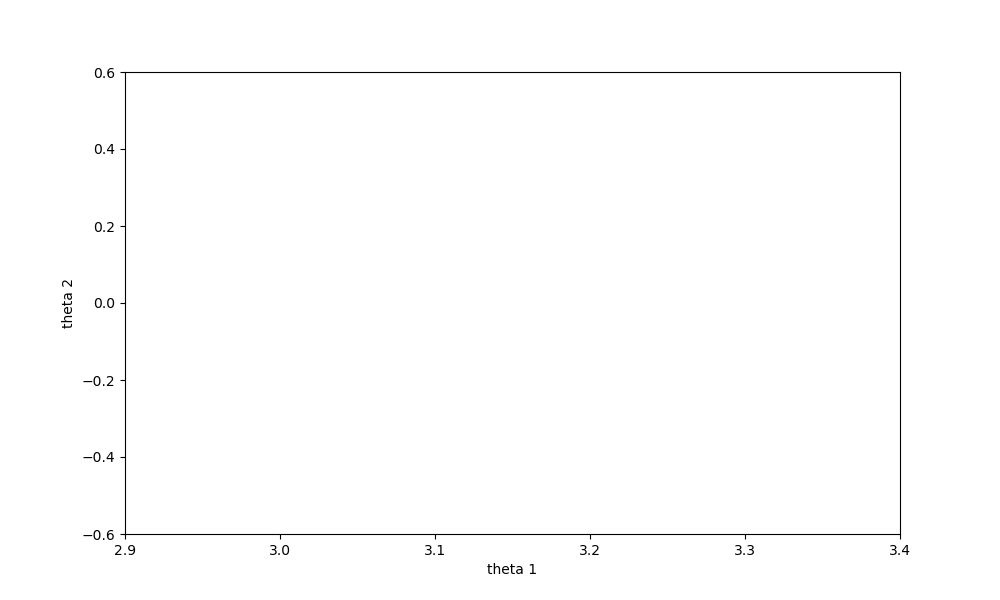

/tmp/ipykernel_13199/527296185.py:23: UserWarning: No contour levels were found within the data range.
  ax.contour(TR1_300,TR2_300, Vplot*1000, levels=[2e-3])


Text(0, 0.5, 'theta 2')

In [35]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#img2 = ax.scatter(TR1[ckkk2], TR2[ckkk2], alpha=0.2)
#img = ax.scatter(TR1[success_indices], TR2[success_indices], alpha=0.2)
#img = ax.scatter(TR1[success_indices_new], TR2[success_indices_new], alpha=0.2)
#img = ax.scatter(TR1_300[success_indices_300], TR2_300[success_indices_300], alpha=0.2)
# img = ax.scatter(TR1_300[success_indices_new_300], TR2_300[success_indices_new_300], alpha=0.2)
# img = ax.scatter(TR1_300[fail_indices_new_300], TR2_300[fail_indices_new_300], alpha=0.2)

Vplot = np.zeros_like(TR1_300)
Vdotplot = np.zeros_like(TR1_300)
env = {s1[0]:0, c1[0]:-1, s2[0]:0, c2[0]:1, td1[0]:0, td2[0]:0}
for i in range(len(TR1_300)):
    for j in range(len(TR1_300[i])): 
        env[s1[0]] = np.sin(TR1_300[i, j])
        env[c1[0]] = np.cos(TR1_300[i, j])
        env[s2[0]] = np.sin(TR2_300[i, j])
        env[c2[0]] = np.cos(TR2_300[i, j])
        Vplot[i, j] = V.Evaluate(env)
        Vdotplot[i, j] = Vdot.Evaluate(env)

ax.contour(TR1_300,TR2_300, Vplot*1000, levels=[2e-3])
# ax.contour(TR1_300, TR2_300, Vdotplot*100, levels=[-2])
ax.set_xlim(2.9, 3.4)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")

In [31]:
result.GetSolution(alpha)

-4.304639489305373e-08

In [11]:
Vdot

<Polynomial "-187.66493636235563*1 + 1.4719561998485036*\dot{t2}(0)^2 + 5.3114061583703593*\dot{t1}(0) * \dot{t2}(0) + 3.7644531843906233*\dot{t1}(0)^2 + 26.397683262822806*c2(0) + 0.010821625261688722*c2(0) * \dot{t2}(0)^2 + -1.1631120532471946*c2(0) * \dot{t1}(0) * \dot{t2}(0) + -0.85913029006627939*c2(0) * \dot{t1}(0)^2 + -1.4985246261066845*c2(0)^2 * \dot{t2}(0)^2 + -4.0881378282507184*c2(0)^2 * \dot{t1}(0) * \dot{t2}(0) + -2.76833073297782*c2(0)^2 * \dot{t1}(0)^2 + 2.3447471235492277*s2(0) * \dot{t2}(0) + -0.95046795484648894*s2(0) * \dot{t1}(0) + 0.014290268836802938*s2(0) * \dot{t1}(0) * \dot{t2}(0)^2 + 0.086136466597522346*s2(0) * \dot{t1}(0)^2 * \dot{t2}(0) + 0.071846197760719446*s2(0) * \dot{t1}(0)^3 + -8.927859823889758*s2(0) * c2(0) * \dot{t2}(0) + -12.089477126199059*s2(0) * c2(0) * \dot{t1}(0) + 0.04317774112821951*s2(0) * c2(0) * \dot{t1}(0) * \dot{t2}(0)^2 + 0.097100045291629161*s2(0) * c2(0) * \dot{t1}(0)^2 * \dot{t2}(0) + 0.053922304163409603*s2(0) * c2(0) * \dot{t1}(

In [12]:
a1 = Vdot.Jacobian(x)

Vdot_Hessian = []
for element in a1: 
    Vdot_Hessian.append(element.Jacobian(x))
Vdot_Hessian = np.array(Vdot_Hessian)

In [13]:
env = {s1[0]:0, c1[0]:-1, s2[0]:0, c2[0]:1, td1[0]:0, td2[0]:0}

Vdot_Hessian_origin = np.zeros_like(Vdot_Hessian)

for i in range(len(Vdot_Hessian)): 
    for j in range(len(Vdot_Hessian[i])): 
        Vdot_Hessian_origin[i, j] = Vdot_Hessian[i, j].Evaluate(env)
        
Vdot_Hessian_origin = np.array(Vdot_Hessian_origin, dtype=float)

In [14]:
np.linalg.eigvals(Vdot_Hessian_origin)

array([ 1.61247978e+02,  2.63785069e+01,  2.83965277e-01, -4.30228860e-02,
        0.00000000e+00,  0.00000000e+00])

In [15]:
type(Vdot_Hessian_origin[0][0])

numpy.float64

In [18]:
prog2 = MathematicalProgram()
prog2.AddIndeterminates(x)

lambda_check_2 = prog2.NewFreePolynomial(Variables(x), 3)
lambda_check_2_2 = prog2.NewFreePolynomial(Variables(x), 3)

prog2.AddSosConstraint(V  - eps*Polynomial((x-x_0).dot(x-x_0)) \
                       + lambda_check_2*trig_1 + lambda_check_2_2*trig_2)

solver = MosekSolver()
result2 = solver.Solve(prog2)

assert result2.is_success(), str(result2.get_solver_details().solution_status)

In [108]:
env = {s1[0]:0, c1[0]:-1, s2[0]:0, c2[0]:1, td1[0]:0, td2[0]:0}
V = V - 4.547473508864641e-13
(V).Evaluate(env)

4.547473508864641e-13

In [43]:
coeff = 1e-5

def find_implicit_lambdas_M(V, Vdot, x, x_0): 
    global coeff
    
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    s_deg = max(V.TotalDegree()-2, 0)

    lambda_trig_1 = prog.NewFreePolynomial(Variables(x), s_deg)
    lambda_trig_2 = prog.NewFreePolynomial(Variables(x), s_deg)
    lambda_, _ = prog.NewSosPolynomial(Variables(x), 4)

    trig_1 = Polynomial(x[0]**2 + x[1]**2 - 1)
    trig_2 = Polynomial(x[2]**2 + x[3]**2 - 1)

    eps = 1e-7

    prog.AddSosConstraint(eps*Polynomial((x-x_0).dot(x-x_0))*(V - 1) + \
                          lambda_trig_1*trig_1 + lambda_trig_2*trig_2 + \
                          -lambda_*Vdot)

    options = SolverOptions()
    options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_acrobot.txt')
    options.SetOption(MosekSolver().solver_id(), "MSK_DPAR_DATA_TOL_X", 1e-6)


    solver = MosekSolver()
    result = solver.Solve(prog, solver_options=options)
    assert result.is_success(), str(result.get_solver_details().solution_status)
    
    lambda_sol = result.GetSolution(lambda_)
    lambda_trig_1_sol = result.GetSolution(lambda_trig_1).RemoveTermsWithSmallCoefficients(coeff)
    lambda_trig_2_sol = result.GetSolution(lambda_trig_2).RemoveTermsWithSmallCoefficients(coeff)
    
    return lambda_sol, lambda_trig_1_sol, lambda_trig_2_sol
    
def find_implicit_v_M(V, Vdot, lambda_, lambda_trig_1, lambda_trig_2, x, x_0): 
    global coeff
    
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    trig_1 = Polynomial(x[0]**2 + x[1]**2 - 1)
    trig_2 = Polynomial(x[2]**2 + x[3]**2 - 1)
    
    eps = 1e-7
    
    lambda_, _ = prog.NewSosPolynomial(Variables(x), 4)
    prog.AddSosConstraint(eps*Polynomial((x-x_0).dot(x-x_0))*(V - 1)  + \
                          lambda_trig_1*trig_1 + lambda_trig_2*trig_2 + \
                          -lambda_*Vdot)
    
    options = SolverOptions()
    options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_acrobot.txt')
    options.SetOption(MosekSolver().solver_id(), "MSK_DPAR_DATA_TOL_X", 1e-6)


    solver = MosekSolver()
    result = solver.Solve(prog, solver_options=options)
    assert result.is_success(), str(result.get_solver_details().solution_status)
    
    return result.GetSolution(lambda_)
    
def alternations_implicit_M(P, B, X): 
    prog = MathematicalProgram()
    t1 = prog.NewIndeterminates(1, "t1")
    t2 = prog.NewIndeterminates(1, "t2")
    s1 = prog.NewIndeterminates(1, "s1")
    c1 = prog.NewIndeterminates(1, "c1")
    s2 = prog.NewIndeterminates(1, "s2")
    c2 = prog.NewIndeterminates(1, "c2")
    td1 = prog.NewIndeterminates(1, "\dot{t1}")
    td2 = prog.NewIndeterminates(1, "\dot{t2}")

    x = np.hstack([s1, c1, s2, c2, td1, td2])
    x_0 = np.array([0, 1, 0, 1, 0, 0])
    z = np.hstack([t1, t2, td1, td2])

    M44 = np.array([[1, 0, 0, 0], \
                  [0, 1, 0, 0], \
                  [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*c2[0], I2 + m2*l1*lc2*c2[0]], \
                  [0, 0, I2 + m2*l1*lc2*c2[0], I2]])

    Mdot44 = np.array([[0, 0, 0, 0], \
                  [0, 0, 0, 0], \
                  [0, 0, -2*m2*l1*lc2*s2[0]*td2[0], -m2*l1*lc2*s2[0]*td2[0]], \
                  [0, 0, -m2*l1*lc2*s2[0]*td2[0], 0]])

    Vz = Polynomial(z.T@M44.T@P@M44@z)

    V = 0
    for m, coeff in Vz.monomial_to_coefficient_map().items(): 
        monomial = coeff
        for i in range(len(x[:-2])): 
            d = m.degree(x[i])
            monomial *= x[i]**d
        for i in range(len(z)):
            d = m.degree(z[i])
            if i==0:
                if d == 1:
                    monomial *= x[0]
                elif d == 2:
                    monomial *= (2-2*x[1])
            elif i==1:
                if d == 1:
                    monomial *= x[2]
                elif d == 2:
                    monomial *= (2-2*x[3])
            elif i==2 or i==3:
                monomial *= x[i+2]**d
        V += monomial

    V = Polynomial(V)

    K2 = B.T@X@M44
    u = -K2@z

    fz = np.array([[td1[0]], \
                   [td2[0]], \
                   [2*m2*l1*lc2*s2[0]*td1[0]*td2[0] + \
                    m2*l1*lc2*s2[0]*td2[0]**2 + \
                        m1*gravity*lc1*s1[0] - m2*gravity*(-l1*s1[0] + lc2*(-s1[0]*c2[0] - c1[0]*s2[0]))], \
                   [- m2*l1*lc2*s2[0]*td1[0]**2 - \
                m2*gravity*lc2*(-s1[0]*c2[0] - c1[0]*s2[0]) + u[0]]])

    Vdotz = fz.T@P@M44@z + z.T@Mdot44.T@P@M44@z + z.T@M44.T@P@Mdot44@z + z.T@M44.T@P@fz
    Vdotz = Polynomial(Vdotz[0])

    Vdot = 0
    for m, coeff in Vdotz.monomial_to_coefficient_map().items(): 
        monomial = coeff
        for i in range(len(x[:-2])): 
            d = m.degree(x[i])
            monomial *= x[i]**d
        for i in range(len(z)):
            d = m.degree(z[i])
            if i==0:
                if d == 1:
                    monomial *= x[0]
                elif d == 2:
                    monomial *= (2-2*x[1])
            elif i==1:
                if d == 1:
                    monomial *= x[2]
                elif d == 2:
                    monomial *= (2-2*x[3])
            elif i==2 or i==3:
                monomial *= x[i+2]**d
        Vdot += monomial

    Vdot = Polynomial(Vdot)
    
    for i in range(1): 
        lambda_, lambda_s1, lambda_s2 = find_implicit_lambdas_M(V, Vdot, x, x_0)
        print(lambda_)
        lambda_2 = find_implicit_v_M(V, Vdot, lambda_, lambda_s1, lambda_s2, x, x_0)
        
    return lambda_, lambda_s1, lambda_s2, lambda_2

lambda_, lambda_s1, lambda_s2, lambda_2 = alternations_implicit_M(P, B, X)

1.6800921867643239e-07*1 + -4.8925867854441216e-23*\dot{t2}(0) + 2.4947906092433601e-08*\dot{t2}(0)^2 + 1.4239084126021634e-25*\dot{t2}(0)^3 + 2.1895047382710857e-08*\dot{t2}(0)^4 + -6.5292335943205498e-23*\dot{t1}(0) + -8.2034207436889974e-09*\dot{t1}(0) * \dot{t2}(0) + 2.2947203074519039e-24*\dot{t1}(0) * \dot{t2}(0)^2 + 5.2595595696094796e-12*\dot{t1}(0) * \dot{t2}(0)^3 + 1.921629679585654e-08*\dot{t1}(0)^2 + -2.6641078058242464e-24*\dot{t1}(0)^2 * \dot{t2}(0) + 2.1898511922136427e-08*\dot{t1}(0)^2 * \dot{t2}(0)^2 + 1.359177763751373e-24*\dot{t1}(0)^3 + 5.7339005111802405e-12*\dot{t1}(0)^3 * \dot{t2}(0) + 2.1896978486554972e-08*\dot{t1}(0)^4 + 4.2390398944750666e-09*c2(0) + -2.4322685632258281e-22*c2(0) * \dot{t2}(0) + 3.2376922584038988e-10*c2(0) * \dot{t2}(0)^2 + -4.2657941422624747e-23*c2(0) * \dot{t2}(0)^3 + -6.3549821996421174e-23*c2(0) * \dot{t1}(0) + -8.2596986715642544e-10*c2(0) * \dot{t1}(0) * \dot{t2}(0) + -5.0628031648652115e-23*c2(0) * \dot{t1}(0) * \dot{t2}(0)^2 + -1.37

In [6]:
    
M_u_calc = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*c2[0], I2 + m2*l1*lc2*c2[0]], \
              [0, 0, I2 + m2*l1*lc2*c2[0], I2]])

K2 = B.T@X@M_u_calc
K2 = np.insert(K2, 1, 0)
K2 = np.insert(K2, 3, 0)
u = -K2@x

M = np.array([[1, 0, 0, 0, 0, 0], \
              [0, 1, 0, 0, 0, 0], \
              [0, 0, 1, 0, 0, 0], \
              [0, 0, 0, 1, 0, 0], \
              [0, 0, 0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*c2[0], I2 + m2*l1*lc2*c2[0]], \
              [0, 0, 0, 0, I2 + m2*l1*lc2*c2[0], I2]])

Mdot = np.array([[0, 0, 0, 0, 0, 0], \
              [0, 0, 0, 0, 0, 0], \
              [0, 0, 0, 0, 0, 0], \
              [0, 0, 0, 0, 0, 0], \
              [0, 0, 0, 0, -2*m2*l1*lc2*s2[0]*td2[0], -m2*l1*lc2*s2[0]*td2[0]], \
              [0, 0, 0, 0, -m2*l1*lc2*s2[0]*td2[0], 0]])

fx = np.array([[c1[0]*td1[0]], \
               [- s1[0]*td1[0]], \
               [c2[0]*td2[0]], \
               [- s2[0]*td2[0]], \
               [2*m2*l1*lc2*s2[0]*td1[0]*td2[0] + \
                m2*l1*lc2*s2[0]*td2[0]**2 + \
                    m1*gravity*lc1*s1[0] - m2*gravity*(-l1*s1[0] + lc2*(-s1[0]*c2[0] - c1[0]*s2[0]))], \
               [- m2*l1*lc2*s2[0]*td1[0]**2 - \
            m2*gravity*lc2*(-s1[0]*c2[0] - c1[0]*s2[0]) + u]])

V = Polynomial(x.T@M.T@S@M@x)
Vdot = fx.T@S@M@x + x.T@Mdot.T@S@M@x + x.T@M.T@S@Mdot@x + x.T@M.T@S@fx
Vdot = Polynomial(Vdot[0])
    

# find_implicit_V(B, X, P, V)    

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 6)

In [37]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control
import pydrake

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression)

from pydrake.solvers.mosek import MosekSolver

from pydrake.all import (AddMultibodyPlantSceneGraph, ControllabilityMatrix,
                         DiagramBuilder, Linearize, LinearQuadraticRegulator,
                         MeshcatVisualizerCpp, Parser, Saturation, SceneGraph,
                         Simulator, StartMeshcat, WrapToSystem)

p = AcrobotParams()

m1 = p.m1()
m2 = p.m2()
l1 = p.l1()
lc1 = p.lc1()
lc2 = p.lc2()
Ic1 = p.Ic1()
Ic2 = p.Ic2()
b1 = p.b1()
b2 = p.b2()
gravity = p.gravity()

I1 = Ic1 + m1*lc1**2
I2 = Ic2 + m2*lc2**2

In [81]:
prog_create = MathematicalProgram()
x = prog_create.NewIndeterminates(4, 'X')
p1 = x[0]
p2 = x[1]
t1d = x[2]
t2d = x[3]

M = np.array([[1, 0, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, (1+p1**2)*(1+p2**2)*(I1+I2+m2*l1**2)+2*m2*l1*lc2*(1+p1**2)*(1-p2**2), \
                                       (1+p1**2)*(1+p2**2)*I2+m2*l1*lc2*(1-p2**2)*(1+p1**2)], 
              [0, 0, I2*(1+p1**2)*(1+p2**2)+m2*l1*lc2*(1+p1**2)*(1-p2**2), I2*(1+p1**2)*(1+p2**2)]])

f3 = -2*m2*l1*lc2*2*p2*t1d*t2d*(1+p1**2) - m2*l1*lc2*2*p2*t2d**2*(1+p1**2) - m1*gravity*lc1*2*p1*(1+p2**2) \
        +m2*gravity*(-l1*2*p1*(1+p2**2) + lc2*(-2*p1*(1-p2**2) - 2*p2*(1-p1**2))) + b1*t1d*(1+p1**2)*(1+p2**2)

f4 = m2*l1*lc2*2*p2*t1d**2*(1+p1**2) + m2*gravity*lc2*(-2*p1*(1-p2**2) - 2*p2*(1-p1**2)) \
                                                                            + b2*t2d*(1+p1**2)*(1+p2**2)

f = np.array([[0.5*(1+p1**2)*t1d], 
              [0.5*(1+p2**2)*t2d], 
              [-f3], 
              [-f4]])

p1d = 0.5*(1+p1**2)*t1d
p2d = 0.5*(1+p2**2)*t2d

Mdot = np.array([[0, 0, 0, 0], 
                 [0, 0, 0, 0], 
                 [0, 0, (2*p2*p2d+2*p1*p1d+2*p1*p2**2*p1d+2*p2*p1**2*p2d)*(I1+I2+m2*l1**2)\
                                 +2*m2*l1*lc2*(-2*p2*p2d+2*p1*p1d-2*p1*p2**2*p1d-2*p2*p1**2*p2d), \
                                     (2*p2*p2d+2*p1*p1d+2*p1*p2**2*p1d+2*p2*p1**2*p2d)*I2\
                                            +m2*l1*lc1*(-2*p2*p2d+2*p1*p1d-2*p1*p2**2*p1d-2*p2*p1**2*p2d)], \
                 [0, 0, I2*(2*p2*p2d+2*p1*p1d+2*p1*p2**2*p1d+2*p2*p1**2*p2d)\
                                             +m2*l1*lc2*(-2*p2*p2d+2*p1*p1d-2*p1*p2**2*p1d-2*p2*p1**2*p2d), \
                                                 I2*(2*p2*p2d+2*p1*p1d+2*p1*p2**2*p1d+2*p2*p1**2*p2d)]])

env = {p1:0, p2:0, t1d:0, t2d:0}
A_general = []
for exp in f: 
    exp_curr = exp[0].Jacobian(x)
    A_general.append(exp_curr)
A_general = np.array(A_general)  

A = np.zeros_like(A_general)
for i, row in enumerate(A_general): 
    for j, elem in enumerate(row): 
        A[i, j] = elem.Evaluate(env)
        
A = np.array(A, dtype=float)


E = np.zeros_like(M)
for i, row in enumerate(M): 
    for j, elem in enumerate(row): 
        if type(elem) == pydrake.symbolic.Expression:
            E[i, j] = elem.Evaluate(env)
        else: 
            E[i, j] = M[i, j]
        
E = np.array(E, dtype=float)

B = np.array([[0], 
              [0], 
              [0], 
              [1]])

In [82]:
E

array([[1.   , 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , 0.   ],
       [0.   , 0.   , 4.663, 2.33 ],
       [0.   , 0.   , 2.33 , 1.33 ]])

In [83]:
A

array([[ 0.  ,  0.  ,  0.5 ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.5 ],
       [49.05, 19.62, -0.1 ,  0.  ],
       [19.62, 19.62, -0.  , -0.1 ]])

In [84]:
Q = np.diag([5, 5, 1, 1])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

In [85]:
K

array([[-517.48601322, -207.23822752, -111.1821983 ,  -52.61768105]])

In [86]:
K2 = B.T@X@M
K2 = K2[0]
u_calc = -1*K2@x
f_new = f.copy()
f_new[3] = f_new[3] + u_calc*(1+p1**2)*(1+p2**2)

env = {p1:0, p2:0, t1d:0, t2d:0}
A_general = []
for exp in f_new: 
    exp_curr = exp[0].Jacobian(x)
    A_general.append(exp_curr)
A_general = np.array(A_general)  

A_cloop = np.zeros_like(A_general)
for i, row in enumerate(A_general): 
    for j, elem in enumerate(row): 
        A_cloop[i, j] = elem.Evaluate(env)
        
A_cloop = np.array(A_cloop, dtype=float)

In [87]:
A_cloop

array([[ 0.00000000e+00,  0.00000000e+00,  5.00000000e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.00000000e-01],
       [ 4.90500000e+01,  1.96200000e+01, -1.00000000e-01,
         0.00000000e+00],
       [ 5.37106013e+02,  2.26858228e+02,  1.11182198e+02,
         5.25176810e+01]])

In [88]:
for elem in f_new[3][0].Jacobian(x): 
    print(elem.Evaluate(env))

537.1060132204102
226.85822752401745
111.18219830461905
52.51768104655957


In [89]:
A - B@K

array([[ 0.00000000e+00,  0.00000000e+00,  5.00000000e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.00000000e-01],
       [ 4.90500000e+01,  1.96200000e+01, -1.00000000e-01,
         0.00000000e+00],
       [ 5.37106013e+02,  2.26858228e+02,  1.11182198e+02,
         5.25176810e+01]])

In [90]:
A_cloop

Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E = E.T)

np.linalg.eigvals(P)

array([7.10528190e+03, 3.43231574e+00, 1.64668418e+00, 6.74785208e-03])

In [91]:
print(P)

[[ 6.00537966e+03  2.55280607e+03  2.90590524e+02 -2.65384577e+01]
 [ 2.55280607e+03  1.08889300e+03  1.23274076e+02 -1.06636528e+01]
 [ 2.90590524e+02  1.23274076e+02  1.44602678e+01 -2.05290299e+00]
 [-2.65384577e+01 -1.06636528e+01 -2.05290299e+00  1.63472281e+00]]


In [92]:
A_cloop = A-B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E = E.T)

np.linalg.eigvals(P)

array([7.10528190e+03, 3.43231574e+00, 1.64668418e+00, 6.74785208e-03])

In [93]:
print(P)

[[ 6.00537966e+03  2.55280607e+03  2.90590524e+02 -2.65384577e+01]
 [ 2.55280607e+03  1.08889300e+03  1.23274076e+02 -1.06636528e+01]
 [ 2.90590524e+02  1.23274076e+02  1.44602678e+01 -2.05290299e+00]
 [-2.65384577e+01 -1.06636528e+01 -2.05290299e+00  1.63472281e+00]]


In [94]:
A_cloop

array([[ 0.00000000e+00,  0.00000000e+00,  5.00000000e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.00000000e-01],
       [ 4.90500000e+01,  1.96200000e+01, -1.00000000e-01,
         0.00000000e+00],
       [ 5.37106013e+02,  2.26858228e+02,  1.11182198e+02,
         5.25176810e+01]])

In [95]:
V = x.T@M.T@P@M@x

In [96]:
Vdot = f.T@P@M@x + x.T@Mdot.T@P@M@x + x.T@M.T@P@Mdot@x + x.T@M.T@P@f

In [97]:
Polynomial(Vdot[0]).TotalDegree()

12

In [98]:
Polynomial(V).TotalDegree()

10

In [99]:
env = {x[0]:0, x[1]:0, x[2]:0, x[3]:0}
V.Evaluate(env)

0.0

<IPython.core.display.Javascript object>


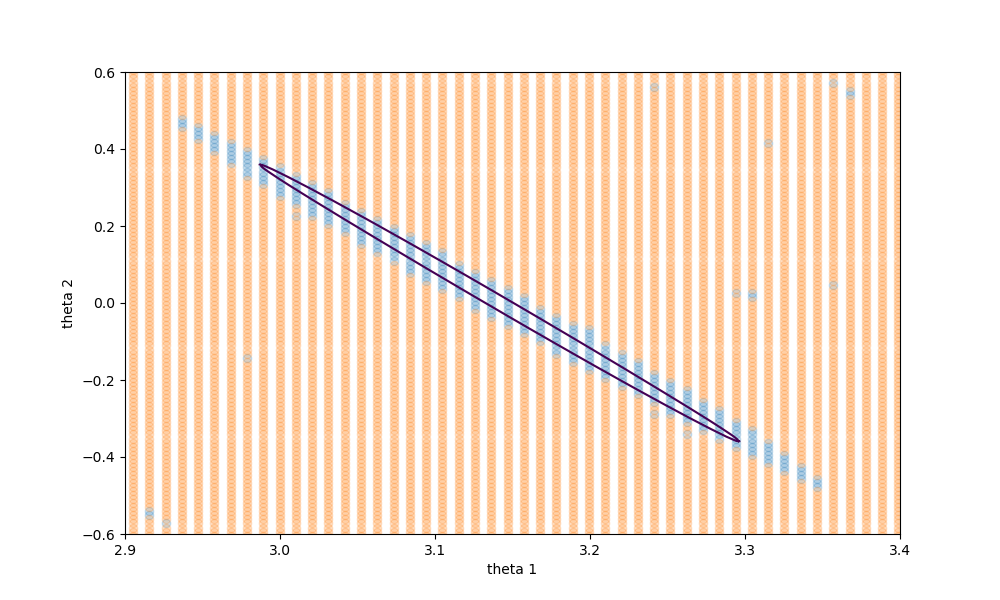

Text(0, 0.5, 'theta 2')

In [29]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#img2 = ax.scatter(TR1[ckkk2], TR2[ckkk2], alpha=0.2)
#img = ax.scatter(TR1[success_indices], TR2[success_indices], alpha=0.2)
#img = ax.scatter(TR1[success_indices_new], TR2[success_indices_new], alpha=0.2)
#img = ax.scatter(TR1_300[success_indices_300], TR2_300[success_indices_300], alpha=0.2)
img = ax.scatter(TR1_300[success_indices_new_300], TR2_300[success_indices_new_300], alpha=0.2)
img = ax.scatter(TR1_300[fail_indices_new_300], TR2_300[fail_indices_new_300], alpha=0.2)

# Vplot = np.zeros_like(TR1_300)
# Vdotplot = np.zeros_like(TR1_300)
# for i in range(len(TR1_300)):
#     for j in range(len(TR1_300[i])): 
#         env[x[0]] = np.sin(TR1_300[i, j] - np.pi)/(1 + np.cos(TR1_300[i, j] - np.pi))
#         env[x[1]] = np.sin(TR2_300[i, j])/(1 + np.cos(TR2_300[i, j]))
#         Vplot[i, j] = V.Evaluate(env)
#         Vdotplot[i, j] = Vdot[0].Evaluate(env)

ax.contour(TR1_3001,TR2_3001, Vplot, levels=[0.12477635493634774])
#ax.contour(TR1_300, TR2_300, Vdotplot*100, levels=[-2])
ax.set_xlim(2.9, 3.4)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")

(517.4860132204102 * X(0) + 207.23822752401745 * X(1) + (X(2) * ( - 17.723447488847203 * (((1 + pow(X(0), 2)) * (1 - pow(X(1), 2))) + 1.3300000000000001 * ((1 + pow(X(0), 2)) * (1 + pow(X(1), 2)))) + 32.699513393444782 * (2 * ((1 + pow(X(0), 2)) * (1 - pow(X(1), 2))) + 2.6630000000000003 * ((1 + pow(X(0), 2)) * (1 + pow(X(1), 2)))))) + (X(3) * (32.699513393444782 * (((1 + pow(X(0), 2)) * (1 - pow(X(1), 2))) + 1.3300000000000001 * ((1 + pow(X(0), 2)) * (1 + pow(X(1), 2)))) - 23.572185160166782 * ((1 + pow(X(0), 2)) * (1 + pow(X(1), 2))))))


<IPython.core.display.Javascript object>


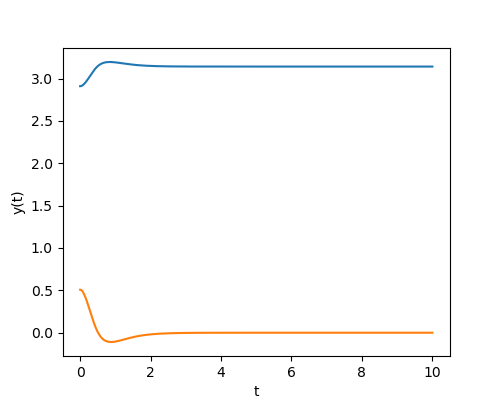

In [100]:
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state
def acrobot_balancing_example(K, x, X, M, B):

    def BalancingLQR():
        # Design an LQR controller for stabilizing the Acrobot around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original AcrobotState coordinates).

        acrobot = AcrobotPlant()
        context = acrobot.CreateDefaultContext()

        input = AcrobotInput()
        input.set_tau(0.)
        acrobot.get_input_port(0).FixValue(context, input)

        context.get_mutable_continuous_state_vector()\
            .SetFromVector(UprightState().CopyToVector())

        Q = np.diag((10., 10., 1., 1.))
        R = [1]

        return LinearQuadraticRegulator(acrobot, context, Q, R)
    
    t1 = Variable("t1")
    t2 = Variable("t2")
    td1 = Variable("td1")
    td2 = Variable("td2")
    garbage = Variable("garbage")
    
    u = -K[0]*(pf.sin(t1-np.pi)/(1+pf.cos(t1-np.pi))) -K[1]*(pf.sin(t2)/(1+pf.cos(t2))) - K[2]*td1 - K[3]*td2
    st = np.hstack([t1, t2, td1, td2])
    
    own_controller = SymbolicVectorSystem(state=[garbage], input=st, dynamics=np.array([0]), output=[u])
    
    
    K2 = B.T@X@M
    u2 = -K2@x
    
    subs = {}
    subs[x[0]] = pf.sin(t1-np.pi)/(1+pf.cos(t1-np.pi))
    subs[x[1]] = pf.sin(t2)/(1+pf.cos(t2))
    subs[x[2]] = td1
    subs[x[3]] = td2
    print(u2[0])
    u2 = u2[0].Substitute(subs)
    #print(u2)
    own_controller_new = SymbolicVectorSystem(state=[garbage], input=st, dynamics=np.array([0]), output=[u2])
    
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-5], max_value=[5]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    controller = builder.AddSystem(own_controller_new)
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)

    # Setup visualization
#     scene_graph = builder.AddSystem(SceneGraph())
#     AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0)
    duration = 10
    for i in range(1):
        context.SetTime(0.)
        np.random.seed(1000)
        trial = np.append(UprightState().CopyToVector(), 0) + 0.05 * np.random.randn(5,)
        trial = UprightState().CopyToVector() + 0.05 * np.random.randn(4,)
        #trial = np.array([np.pi, 0.05, 0, 0, 0])
        trial = np.array([2.91, 0.508, 0, 0, 0])
        context.SetContinuousState(trial)
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        
        plt.figure(figsize=(5, 4))
        plt.plot(log.sample_times(), log.data().transpose()[:, :2])
        plt.xlabel('t')
        plt.ylabel('y(t)')

acrobot_balancing_example(K[0], x, X, M, B)

In [141]:
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state
def acrobot_balancing_example(K, x, X, M, B):

    def BalancingLQR():
        # Design an LQR controller for stabilizing the Acrobot around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original AcrobotState coordinates).

        acrobot = AcrobotPlant()
        context = acrobot.CreateDefaultContext()

        input = AcrobotInput()
        input.set_tau(0.)
        acrobot.get_input_port(0).FixValue(context, input)

        context.get_mutable_continuous_state_vector()\
            .SetFromVector(UprightState().CopyToVector())

        Q = np.diag((5., 5., 1., 1.))
        R = [1]

        return LinearQuadraticRegulator(acrobot, context, Q, R)
    
    t1 = Variable("t1")
    t2 = Variable("t2")
    td1 = Variable("td1")
    td2 = Variable("td2")
    garbage = Variable("garbage")
    
    u = -K[0]*(pf.sin(t1-np.pi)/(1+pf.cos(t1-np.pi))) -K[1]*(pf.sin(t2)/(1+pf.cos(t2))) - K[2]*td1 - K[3]*td2
    st = np.hstack([t1, t2, td1, td2])
    
    own_controller = SymbolicVectorSystem(state=[garbage], input=st, dynamics=np.array([0]), output=[u])
    
    
    K2 = B.T@X@M
    u2 = -K2@x
    
    subs = {}
    subs[x[0]] = pf.sin(t1-np.pi)/(1+pf.cos(t1-np.pi))
    subs[x[1]] = pf.sin(t2)/(1+pf.cos(t2))
    subs[x[2]] = td1
    subs[x[3]] = td2
    u2 = u2[0].Substitute(subs)
    #print(u2)
    own_controller_new = SymbolicVectorSystem(state=[garbage], input=st, dynamics=np.array([0]), output=[u2])
    
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-3], max_value=[3]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    controller = builder.AddSystem(own_controller_new)
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)

    # Setup visualization
#     scene_graph = builder.AddSystem(SceneGraph())
#     AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0)
    duration = 16
    
    t_grid_1 = np.linspace(2.7, 3.6, 100)
    t_grid_2 = np.linspace(-0.8, 0.8, 100)
    t_grid_1, t_grid_2 = np.meshgrid(t_grid_1, t_grid_2)
    
    works = np.zeros_like(t_grid_1)
    for i in range(len(t_grid_1)):
        for j in range(len(t_grid_1[i])): 
            context.SetTime(0.)
            np.random.seed(1000)
#             trial = np.append(UprightState().CopyToVector(), 0) + 0.05 * np.random.randn(5,)
#             trial = UprightState().CopyToVector() + 0.05 * np.random.randn(4,)
            #trial = np.array([np.pi, 0.05, 0, 0, 0])
            trial = np.array([t_grid_1[i, j], t_grid_2[i,j], 0, 0, 0])
            context.SetContinuousState(trial)
            simulator.Initialize()
            try: 
                simulator.AdvanceTo(duration)

                log = logger.FindLog(context)
                end_state = log.data()[:, -1]
    #             print(end_state)
                diff = np.abs(end_state - UprightState().CopyToVector())
    #             print(diff)
                if np.sum(diff < np.ones(4)*5e-2) == 4: 
                    works[i, j] = 1
            except: 
                pass
            #print(j)
        
        print(i)
#         plt.figure(figsize=(5, 4))
#         plt.plot(log.sample_times(), log.data().transpose()[:, :2])
#         plt.xlabel('t')
#         plt.ylabel('y(t)')

    return works, t_grid_1, t_grid_2

works, t_grid_1, t_grid_2 = acrobot_balancing_example(K[0], x, X, M, B)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [144]:
TR1_300 = t_grid_1
TR2_300 = t_grid_2
success_indices_new_st_300 = np.where(works == 1)
fail_indices_new_st_300 = np.where(works == 0)

<IPython.core.display.Javascript object>


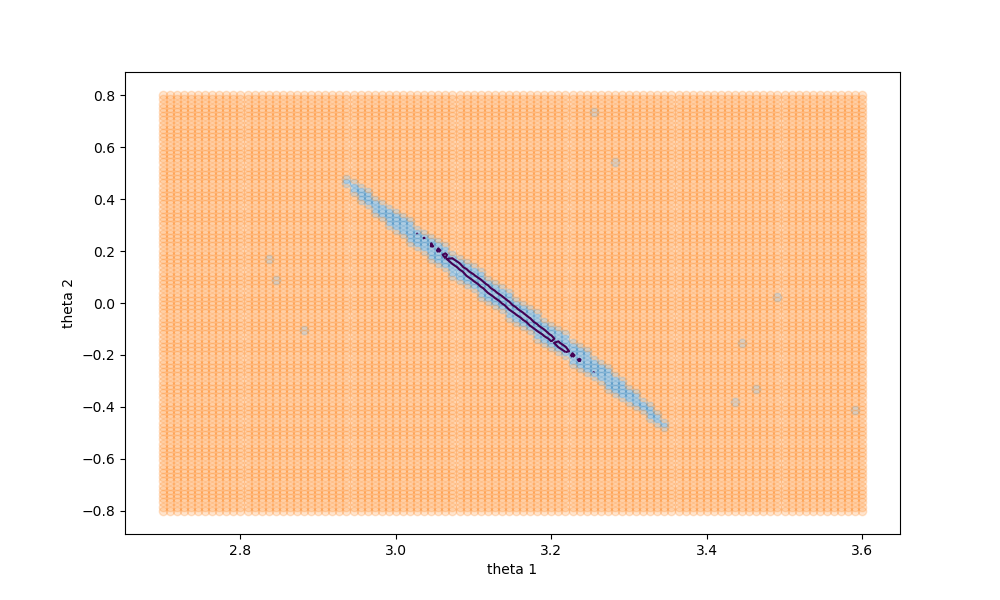

Text(0, 0.5, 'theta 2')

In [145]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#img2 = ax.scatter(TR1[ckkk2], TR2[ckkk2], alpha=0.2)
#img = ax.scatter(TR1[success_indices], TR2[success_indices], alpha=0.2)
#img = ax.scatter(TR1[success_indices_new], TR2[success_indices_new], alpha=0.2)
#img = ax.scatter(TR1_300[success_indices_300], TR2_300[success_indices_300], alpha=0.2)
img = ax.scatter(TR1_300[success_indices_new_st_300], TR2_300[success_indices_new_st_300], alpha=0.2)
img = ax.scatter(TR1_300[fail_indices_new_st_300], TR2_300[fail_indices_new_st_300], alpha=0.2)

Vplot = np.zeros_like(TR1_300)
# Vdotplot = np.zeros_like(TR1_300)
for i in range(len(TR1_300)):
    for j in range(len(TR1_300[i])): 
        env[x[0]] = np.sin(TR1_300[i, j] - np.pi)/(1 + np.cos(TR1_300[i, j] - np.pi))
        env[x[1]] = np.sin(TR2_300[i, j])/(1 + np.cos(TR2_300[i, j]))
        Vplot[i, j] = V.Evaluate(env)
#         Vdotplot[i, j] = Vdot[0].Evaluate(env)

ax.contour(TR1_300,TR2_300, Vplot, levels=[0.07])
#ax.contour(TR1_300, TR2_300, Vdotplot*100, levels=[-2])
# ax.set_xlim(2.9, 3.4)
# ax.set_ylim(-0.6, 0.6)
ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")

In [143]:
np.save('./stereographic_new_100by100_t1.npy', t_grid_1)
np.save('./stereographic_new_100by100_t2.npy', t_grid_2)
np.save('./stereographic_new_worked_100by100.npy', works)

In [22]:
Polynomial(V).TotalDegree()

10

In [22]:
fail_indices_new_300

(array([], dtype=int64), array([], dtype=int64))

In [65]:
K

array([[-523.43456244, -209.8566193 , -112.47195778,  -53.25332814]])

In [88]:
K_original

array([[-278.44223126, -112.29125985, -119.72457377,  -56.82824017]])

In [19]:
K

array([[-523.43456244, -209.8566193 , -112.47195778,  -53.25332814]])

In [153]:
TR1_300 = np.load('./300by300TR1.npy')
TR2_300 = np.load('./300by300TR2.npy')
worked_arr_300 = np.load('./worked_arr_300.npy')
V_eval_arr_300 = np.load('./V_eval_arr_300.npy')
worked_arr_new_300 = np.load('./worked_arr_new_300.npy')
V_eval_arr_new_300 = np.load('./V_eval_arr_new_300.npy')
success_indices_new_300 = np.where(worked_arr_new_300 == 1)
success_indices_300 = np.where(worked_arr_300 == 1)
fail_indices_new_300 = np.where(worked_arr_new_300 == 0)
fail_indices_300 = np.where(worked_arr_300 == 0)

<IPython.core.display.Javascript object>


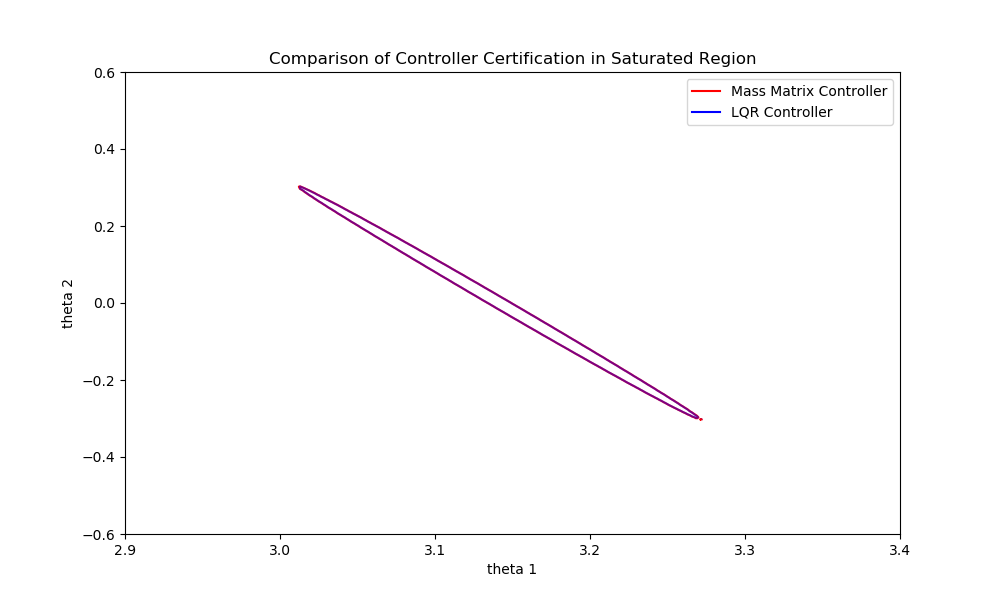

Text(0.5, 1.0, 'Comparison of Controller Certification in Saturated Region')

In [180]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#img2 = ax.scatter(TR1[ckkk2], TR2[ckkk2], alpha=0.2)
#img = ax.scatter(TR1[success_indices], TR2[success_indices], alpha=0.2)
#img = ax.scatter(TR1[success_indices_new], TR2[success_indices_new], alpha=0.2)
#img = ax.scatter(TR1_300[success_indices_300], TR2_300[success_indices_300], alpha=0.2)
# img = ax.scatter(t_grid_1[success_indices_new_st_300], t_grid_2[success_indices_new_st_300], alpha=0.4, \
#                 label='Grid Based Empirical')
# img2 = ax.scatter(TR1_300[success_indices_300], TR2_300[success_indices_300], \
#                   alpha=0.2, label='Grid Based Empirical')
#img = ax.scatter(TR1_300[fail_indices_300], TR2_300[fail_indices_300], alpha=0.2)
# img = ax.scatter(t_grid_1[fail_indices_new_st_300], t_grid_2[fail_indices_new_st_300], alpha=0.2)

Vplot = np.zeros_like(tg1)
# Vdotplot = np.zeros_like(TR1_300)
for i in range(len(tg1)):
    for j in range(len(tg1[i])): 
        env[x[0]] = np.sin(tg1[i, j] - np.pi)/(1 + np.cos(tg1[i, j] - np.pi))
        env[x[1]] = np.sin(tg2[i, j])/(1 + np.cos(tg2[i, j]))
        Vplot[i, j] = V.Evaluate(env)
#         Vdotplot[i, j] = Vdot[0].Evaluate(env)

img_n = ax.contour(tg1, tg2, Vplot, levels=[0.089418], colors='r')
img_n = ax.contour(tg1, tg2, Vplot, levels=[0.08804], colors='b', alpha=0.5)
img_n = plt.plot(0, 0, label='Mass Matrix Controller', color='r')
img_n = plt.plot(0, 0, label='LQR Controller', color='b')

ax.set_xlim(2.9, 3.4)
ax.set_ylim(-0.6, 0.6)
ax.legend()
ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")
ax.set_title('Comparison of Controller Certification in Saturated Region')

In [147]:
tg1 = np.load('./stereographic_new_300by300_t1.npy')
tg2 = np.load('./stereographic_new_300by300_t2.npy')
# works_n = np.load('./stereographic_new_worked.npy')
# success_indices_new_st_300 = np.where(works == 1)
# fail_indices_new_st_300 = np.where(works == 0)